<a id="title"></a>
# <div style="text-align:center; padding:7px; color:white; margin:0; font-size:150%; font-family:Arial; background-color:#1e3f5a; overflow:hidden"><b> DQLab Store - Sales Analysis </b></div>

In this notebook, I will analyze the DQLAb Store's historical sales data from 2009 to 2012. The dataset includes three main product categories: Office Supplies, Technology, and Furniture, each with multiple sub-categories. Additionally, the company offers promotions in the form of discounts, which will also be explored in this analysis.

Here some information on the columns:

| Column Name         | Description                                                                                      |
|---------------------|--------------------------------------------------------------------------------------------------|
| **order_id**        | Unique order number                                                                              |
| **order_status**    | Status of the order, whether it is finished or returned                                          |
| **customer**        | Customer name                                                                                    |
| **order_date**      | Date of the order                                                                                |
| **order_quantity**  | The quantity in a particular order                                                               |
| **sales**           | Sales generated in a particular order, the value is in IDR (Indonesian Rupiah) currency          |
| **discount**        | Discount percentage applied to the order                                                         |
| **discount_value**  | The discount value, calculated as sales multiplied by discount, the value is in IDR currency     |
| **product_category**| The category of the product                                                                      |
| **product_sub_category** | The subcategory within the product category                                                  |


<a id="h1"></a>
# <div style="text-align:center; padding:7px; color:white; margin:0; font-size:110%; font-family:Arial; background-color:#1e3f5a; overflow:hidden"><b> 1. Imports and Overview </b></div>

## Package and Function Imports

In [1]:
!rm -rf utilities
!git clone https://github.com/BeJa1996/utilities

Cloning into 'utilities'...
remote: Enumerating objects: 99, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 99 (delta 57), reused 0 (delta 0), pack-reused 0 (from 0)
Unpacking objects: 100% (99/99), 41.15 KiB | 714.00 KiB/s, done.


In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

from utilities.Helper_Functions import check_index, groupings, hist_num, scatter_num, countplot_cat

## Data Import

In [3]:
df = pd.read_csv('/kaggle/input/sales-performance-report-dqlab-store/clean_data.csv')
df.shape

(5499, 10)

In [4]:
df.head()

,order_id,order_status,customer,order_date,order_quantity,sales,discount,discount_value,product_category,product_sub_category
0,3,Order Finished,Muhammed Mac Intyre,2010-10-13,6,523080,0.04,20923,Office Supplies,Storage & Organization
1,293,Order Finished,Barry French,2012-10-01,49,20246040,0.07,1417223,Office Supplies,Appliances
2,483,Order Finished,Clay Rozendal,2011-07-10,30,9931519,0.08,794522,Technology,Telephones & Communication
3,515,Order Finished,Carlos Soltero,2010-08-28,19,788540,0.08,63083,Office Supplies,Appliances
4,613,Order Finished,Carl Jackson,2011-06-17,12,187080,0.03,5612,Office Supplies,Binders & Binder Accessories


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5499 entries, 0 to 5498
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   order_id              5499 non-null   int64  
 1   order_status          5499 non-null   object 
 2   customer              5499 non-null   object 
 3   order_date            5499 non-null   object 
 4   order_quantity        5499 non-null   int64  
 5   sales                 5499 non-null   int64  
 6   discount              5499 non-null   float64
 7   discount_value        5499 non-null   int64  
 8   product_category      5499 non-null   object 
 9   product_sub_category  5499 non-null   object 
dtypes: float64(1), int64(4), object(5)
memory usage: 429.7+ KB


## Data Cleaning
It looks like there is not much data cleaning to perform. The above info shows that there are no missings and in the next code-cell you see that there are no duplicates. 

In [6]:
print("There are ", df.duplicated().sum(), " Duplicates.")

There are  0  Duplicates.


In [7]:
_= check_index(df)

The index seems to be fine.


Order ID is apparently not a suitable index and leaves us with some problems. 

In [8]:
problems = check_index(df, 'order_id')

Non-Unique Column: 3 instances found.
Listing all:
[29795, 31781, 40519]
Missing rows in Column: 54475 instances found.
Showing the first 20:
[4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


At first, there are some duplicate entries. Apparently, they occur if a customer cancels an order. The question arises, which entry we should delete. Either the order was not finished, but cancelled and the system wrote finished nonetheless. This would best explain the pattern in the first two instances, or the person cancelles an order and then created a new order with the same id (which should not happen). This fits the third pattern. As this would also fit the first two patterns (although not as good as the other explanation), I would go with that and take out the cancellations. 

In [9]:
df[df['order_id'] == problems['duplicates'][0]]

,order_id,order_status,customer,order_date,order_quantity,sales,discount,discount_value,product_category,product_sub_category
185,29795,Order Finished,Grant Carroll,2011-11-25,49,38650400,0.05,1932520,Office Supplies,Binders & Binder Accessories
186,29795,Order Cancelled,Grant Carroll,2011-11-25,49,38650400,0.05,1932520,Office Supplies,Binders & Binder Accessories


In [10]:
df[df['order_id'] == problems['duplicates'][1]]

,order_id,order_status,customer,order_date,order_quantity,sales,discount,discount_value,product_category,product_sub_category
200,31781,Order Finished,Sylvia Foulston,2009-01-16,46,498040,0.1,49804,Office Supplies,Binders & Binder Accessories
201,31781,Order Cancelled,Sylvia Foulston,2009-01-16,46,498040,0.1,49804,Office Supplies,Binders & Binder Accessories


In [11]:
df[df['order_id'] == problems['duplicates'][2]]

,order_id,order_status,customer,order_date,order_quantity,sales,discount,discount_value,product_category,product_sub_category
244,40519,Order Cancelled,N UL L,2009-03-13,3,35040,0.05,1752,Office Supplies,Binders & Binder Accessories
5453,40519,Order Finished,Sandra Glassco,2010-12-21,38,165860,0.08,13269,Office Supplies,Rubber Bands


In [12]:
df[df['order_status'].str.contains('Order Cancelled')]

,order_id,order_status,customer,order_date,order_quantity,sales,discount,discount_value,product_category,product_sub_category
186,29795,Order Cancelled,Grant Carroll,2011-11-25,49,38650400,0.05,1932520,Office Supplies,Binders & Binder Accessories
201,31781,Order Cancelled,Sylvia Foulston,2009-01-16,46,498040,0.10,49804,Office Supplies,Binders & Binder Accessories
244,40519,Order Cancelled,N UL L,2009-03-13,3,35040,0.05,1752,Office Supplies,Binders & Binder Accessories


In [13]:
cancelled = df[df['order_status'].str.contains('Order Cancelled')]
df = df[~df['order_status'].str.contains('Order Cancelled')]

Furthermore, we see that not all order_ids are in their. We can not do much about that. 

## Feature Engineering 
Lastly, we should make a date column out of our date column and also create day, month and year columns.

In [14]:
df['order_date'] = pd.to_datetime(df['order_date'])
df['year'] = df['order_date'].dt.year
df['month'] = df['order_date'].dt.month
df['weekday'] = df.order_date.dt.day_of_week

<a id="h2"></a>
# <div style="text-align:center; padding:7px; color:white; margin:0; font-size:110%; font-family:Arial; background-color:#1e3f5a; overflow:hidden"><b> 2. EDA </b></div>

## Our Columns

We see that Order ID, Order Quantity and Discount are mostly uniform distributed. Sales and discount values however are extremely skewed. 

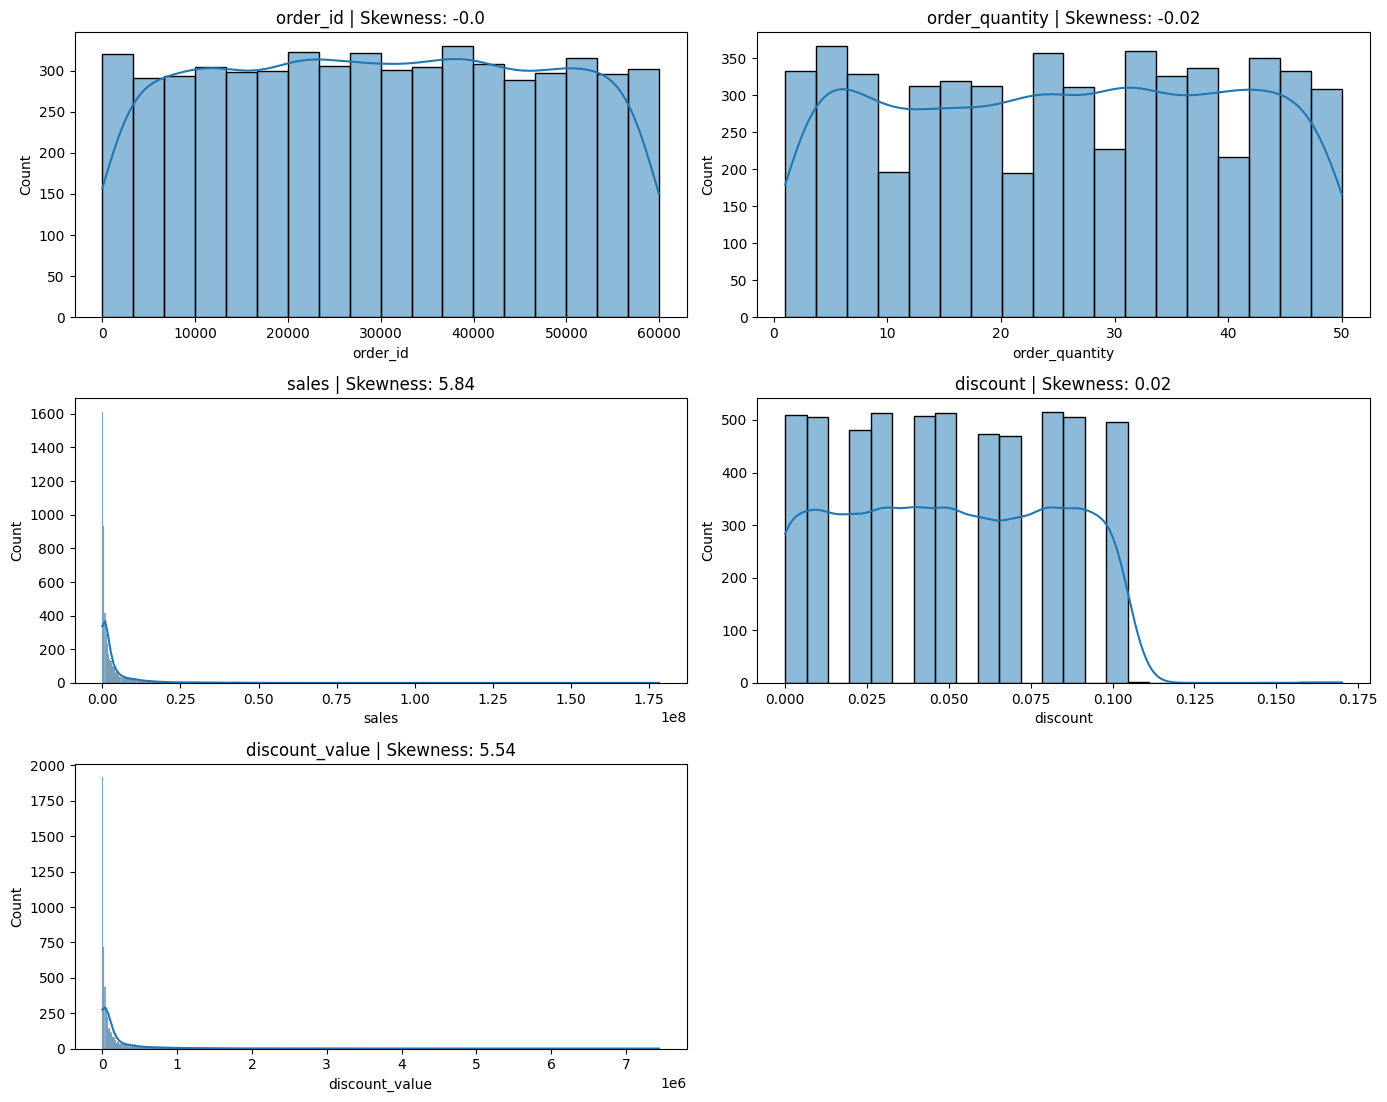

In [15]:
hist_num(df)

Most orders are finished. Some return, three were cancelled (but are already excluded).

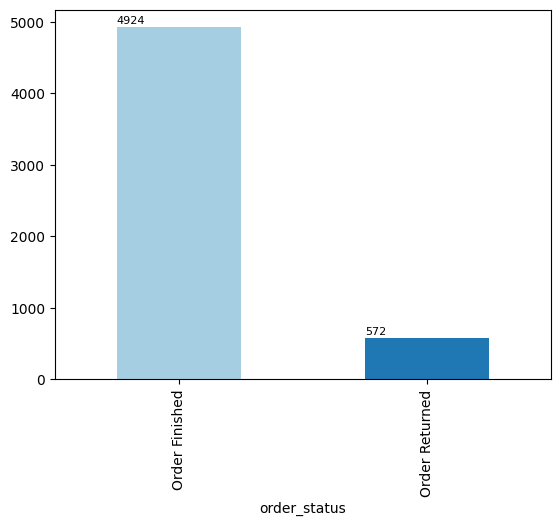

In [16]:
_ = groupings(df, 'order_status')

Lets see how often different categories where sold. In terms of frequency, office supplies are the most important products. 

In [17]:
temp = df.groupby(['product_category', 'product_sub_category'], as_index = False)['order_id'].count()
temp.rename(columns = {'product_category': 'Category',
                      'product_sub_category': 'Subcategory',
                      'order_id': 'Count'}, inplace = True)
fig = px.sunburst(
    temp, path = ['Category', 'Subcategory'],
    values='Count'
)
fig.update_traces(textinfo="label+percent parent")
fig.show()

Because there are too many customers, let us have a look at the distribution of frequencies with which the customers order. E.g. Only one or two customers ordered 40 times, whereas 100 customers ordered around 5 times. This means, most customers did not buy that frequently. 

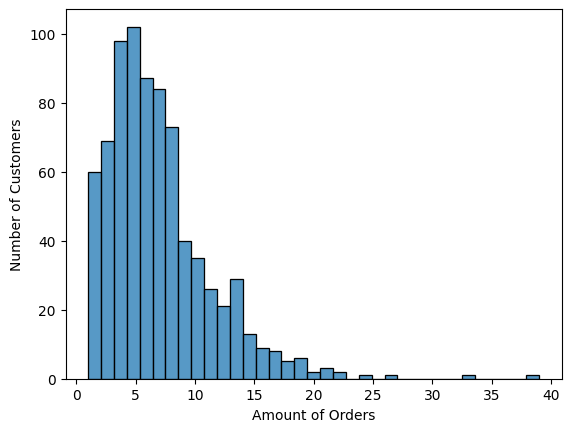

In [18]:
sns.histplot(df.groupby('customer')['order_id'].count())
plt.xlabel('Amount of Orders')
plt.ylabel('Number of Customers')
plt.show()

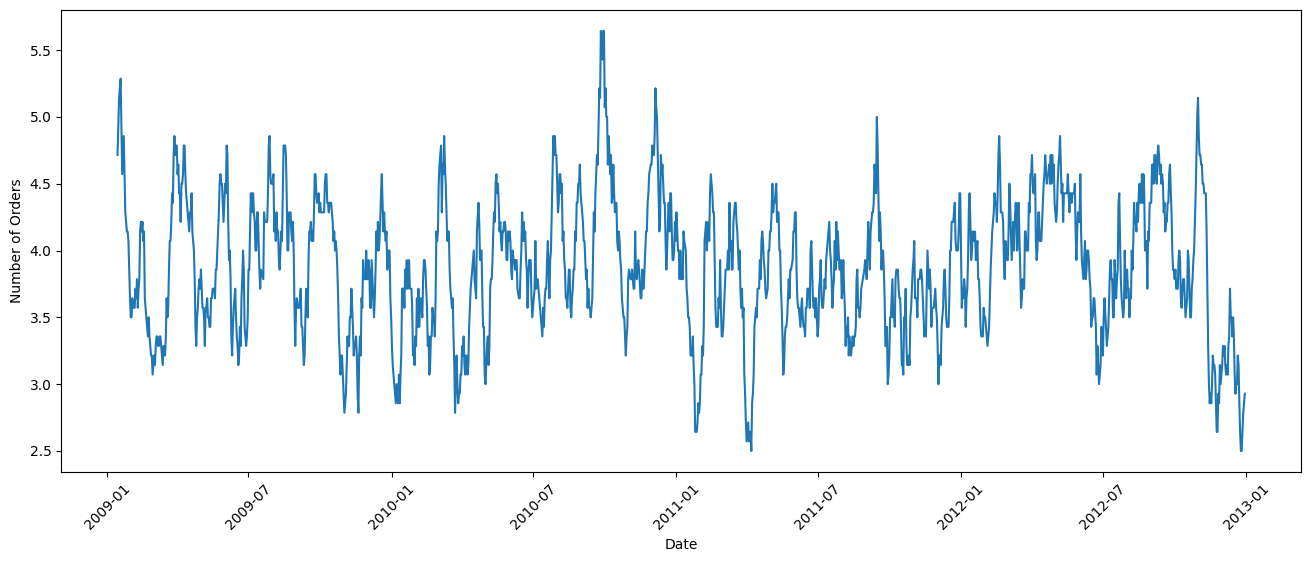

In [19]:
plt.figure(figsize=(16, 6))
temp = df.groupby(['order_date'])['order_id'].count()
temp_rolling = temp.rolling(window=14).mean() 
sns.lineplot(x=temp.index, y=temp_rolling)
plt.xticks(rotation=45) 
plt.ylabel('Number of Orders')
plt.xlabel('Date')
plt.show()

## What does it mean for sales?

Let us investigate how the sales for finished orders look like.

In [20]:
completed_orders = df[df['order_status'] == 'Order Finished']

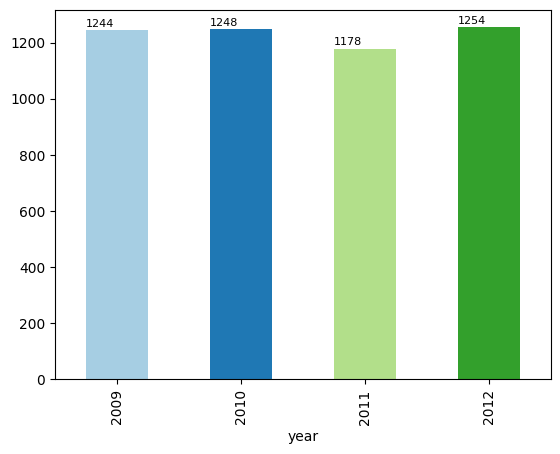

In [21]:
year_sales = groupings(completed_orders, by = 'year', target = 'sales', 
                       method = 'count', sort = False)

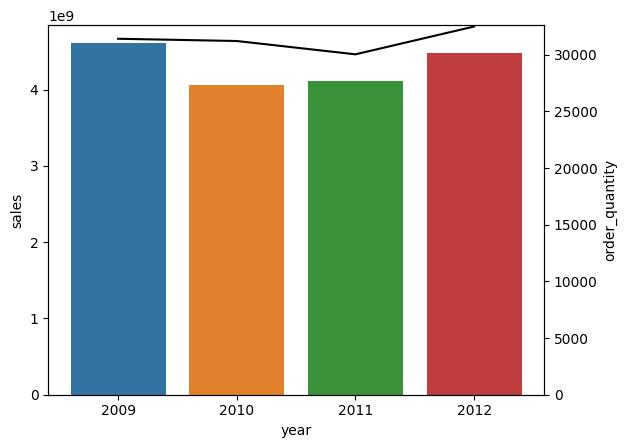

In [22]:
temp = completed_orders.groupby('year').agg({'order_quantity': sum, 'sales': sum})
temp = temp.reset_index()
temp['year'] = temp['year'].astype(str)
ax = sns.barplot(x='year', y='sales', data=temp)
ax2 = ax.twinx()
sns.lineplot(x='year', y='order_quantity', data=temp, ax=ax2, color = 'black')
ax2.set_ylim(bottom=0)
plt.show()

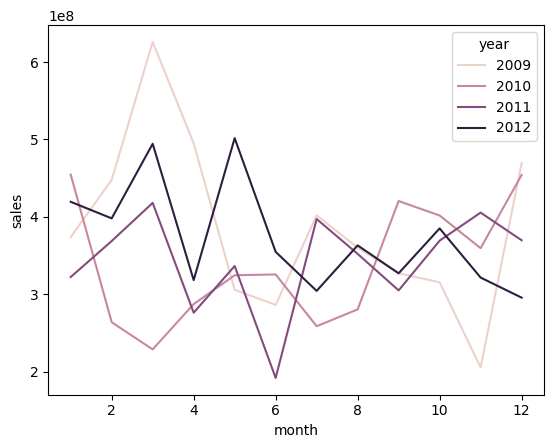

In [23]:
monthly_sales = groupings(completed_orders, by = ['year','month'], target = 'sales', 
                         method='sum',sort = False, plot = False)
monthly_sales = monthly_sales.reset_index()
sns.lineplot(monthly_sales, x = 'month', y = 'sales', hue = 'year')
plt.show()

In [24]:
temp = completed_orders.groupby(['product_category', 
                                 'product_sub_category'], as_index = False)['sales'].sum()
temp.rename(columns = {'product_category': 'Category',
                      'product_sub_category': 'Subcategory',
                      'sales': 'Sales'}, inplace = True)
fig = px.sunburst(
    temp, path = ['Category', 'Subcategory'],
    values='Sales'
)
fig.update_traces(textinfo="label+percent parent")
fig.show()

# 3. Customer Segmentation
I want to segment customers into groups.

## Transformation
 For that I need to transform the dataset. I want to know how often they ordered (also how often in the given days that they were activ), how high their discounts where, how often they returned and their sales and order numbers for the different categories. 

In [25]:
df['returned'] = df['order_status'] =='Order Returned'
agg = {'order_date': [min, max], 'discount': 'mean', 
       'returned': 'mean', 'sales': sum, 'order_quantity': sum}
temp = df.groupby(['customer']).agg(agg).reset_index()
temp.columns = ['Customer', 'First_Order', 'Last_Order', 
                'Average_Discount','Average_Returned', 'Sales', 'Order_Quantity']
temp.head()

,Customer,First_Order,Last_Order,Average_Discount,Average_Returned,Sales,Order_Quantity
0,Aaron Bergman,2011-05-28,2011-05-28,0.010000,0.000000,29520,5
1,Aaron Hawkins,2009-08-15,2011-12-29,0.052222,0.222222,41508640,274
2,Aaron Smayling,2009-01-21,2012-01-19,0.040000,0.000000,9911260,192
3,Adam Bellavance,2009-05-15,2012-10-02,0.043636,0.181818,21396920,296
4,Adam Hart,2009-01-28,2012-12-11,0.060000,0.000000,29730930,326


In [26]:
agg = {'sales': sum}
temp2 = completed_orders.groupby(['customer', 'product_category']).agg(agg).reset_index()
temp2 = pd.pivot(temp2, index = 'customer', columns = 'product_category', 
         values = ['sales']).reset_index()
temp2[temp2.isna()] = 0
temp2.columns = ['Customer', 'Furniture', 'Office', 'Technology']
temp2.head()

,Customer,Furniture,Office,Technology
0,Aaron Bergman,0.0,29520.0,0.0
1,Aaron Hawkins,30255100.0,10572840.0,0.0
2,Aaron Smayling,6623660.0,3287600.0,0.0
3,Adam Bellavance,12409120.0,8579600.0,0.0
4,Adam Hart,5648240.0,8745320.0,15337370.0


In [27]:
customers = pd.merge(temp, temp2, on = 'Customer')
customers['Duration_Relationship'] = customers.Last_Order - customers.First_Order
customers['Duration_Relationship'] = customers['Duration_Relationship'].dt.days
customers['Duration_Relationship'] = np.where(customers['Duration_Relationship'] == 0, 
                                              1, customers['Duration_Relationship'])
for column in ['Furniture','Office','Technology']:
    customers[column] = customers[column]/customers['Sales']*100
    
customers.head()

,Customer,First_Order,Last_Order,Average_Discount,Average_Returned,Sales,Order_Quantity,Furniture,Office,Technology,Duration_Relationship
0,Aaron Bergman,2011-05-28,2011-05-28,0.010000,0.000000,29520,5,0.000000,100.000000,0.000000,1
1,Aaron Hawkins,2009-08-15,2011-12-29,0.052222,0.222222,41508640,274,72.888681,25.471420,0.000000,866
2,Aaron Smayling,2009-01-21,2012-01-19,0.040000,0.000000,9911260,192,66.829646,33.170354,0.000000,1093
3,Adam Bellavance,2009-05-15,2012-10-02,0.043636,0.181818,21396920,296,57.994889,40.097360,0.000000,1236
4,Adam Hart,2009-01-28,2012-12-11,0.060000,0.000000,29730930,326,18.997858,29.414889,51.587253,1413


## Segmentation

In [28]:
temp = customers.iloc[:, list(range(3, customers.shape[1]))]
temp = temp.drop(['Furniture', 'Office', 'Technology', 'Sales'], axis = 1)
temp.dtypes

Average_Discount         float64
Average_Returned         float64
Order_Quantity             int64
Duration_Relationship      int64
dtype: object

The graph below is not what you want to see when determining the number of clusters, because there is no clear cutoff point.

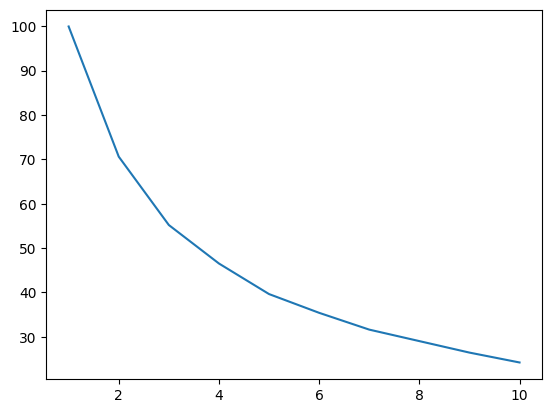

In [29]:
# https://stackabuse.com/k-means-clustering-with-scikit-learn/
scaler = MinMaxScaler()
temp_norm = scaler.fit_transform(temp)

wcss = []
ks = []
for number_of_clusters in range(1, 11): 
    ks.append(number_of_clusters)
    kmeans = KMeans(n_clusters = number_of_clusters)
    kmeans.fit(temp_norm) 
    wcss.append(kmeans.inertia_)

plt.plot(ks, wcss)

So let's determine the point according to content. How do the values actually differ?

In [30]:
def kmeans_content(n):
    kmeans = KMeans(n_clusters = n)
    kmeans.fit(temp_norm)
    res = pd.DataFrame(kmeans.cluster_centers_, columns = temp.columns)
    res.std(axis=0).sort_values(ascending = False).plot.bar(color=plt.cm.Paired(np.arange(res.shape[1])))
    plt.xticks(rotation=90)
    cluster = kmeans.labels_.astype(str)
    return cluster

With two clusters the main differentiating feaures is the duration of the relationship, and maybe Order Quantity.

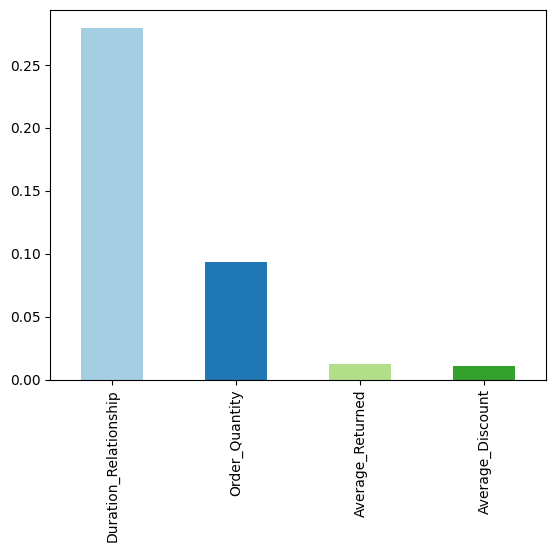

In [31]:
cluster = kmeans_content(2)

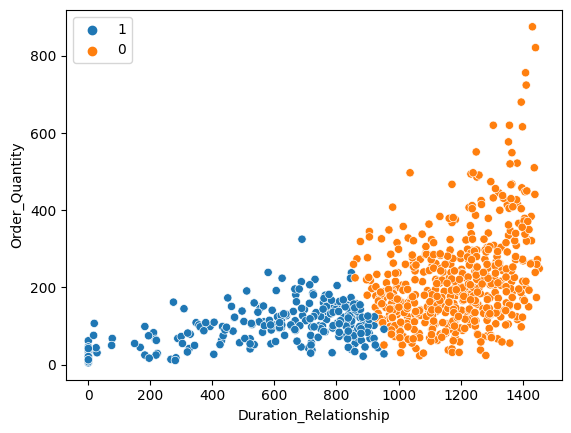

In [32]:
sns.scatterplot(customers, x='Duration_Relationship', y='Order_Quantity', 
                hue=cluster)
plt.show()

With three groups, we see that average returned and duration of the relationship is relevant. 

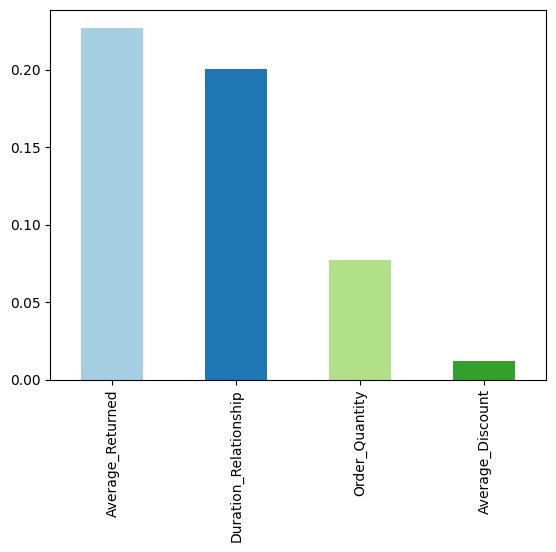

In [33]:
cluster = kmeans_content(3)

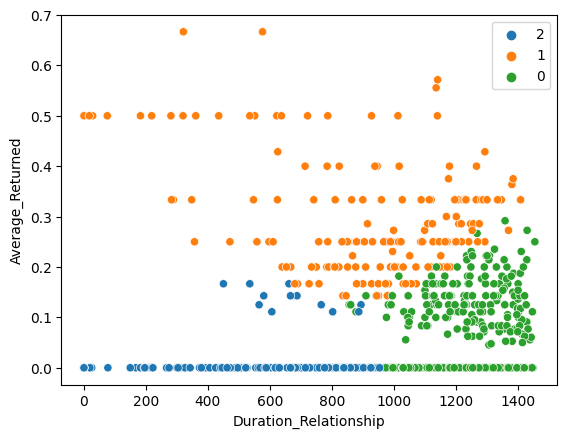

In [34]:
sns.scatterplot(customers, x='Duration_Relationship', y='Average_Returned', 
                hue=cluster)
plt.show()

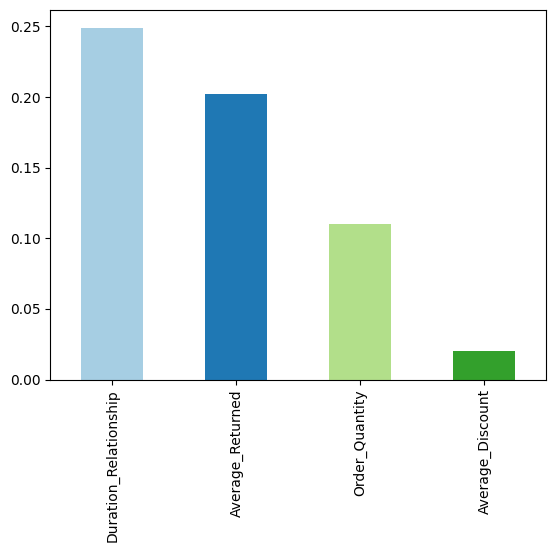

In [35]:
cluster = kmeans_content(4)

In [36]:
fig = px.scatter_3d(customers, x='Duration_Relationship', y='Average_Returned', 
                    z='Order_Quantity', color=cluster, size = 'Sales')
fig.show()

In [37]:
customers['cluster'] = cluster
customers.groupby('cluster')[temp.columns.to_list() + ['Sales']].mean()

,Average_Discount,Average_Returned,Order_Quantity,Duration_Relationship,Sales
cluster,,,,,
0,0.051759,0.012216,137.362369,1034.891986,1.723612e+07
1,0.049779,0.108587,306.674107,1277.794643,4.413394e+07
2,0.048551,0.297534,143.685185,919.080247,2.072308e+07
3,0.046912,0.010835,86.196078,418.323529,1.163916e+07
